In [64]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import pearsonr
import itertools
import scipy.stats as ss
from scipy.stats import pointbiserialr
from scipy import stats
from scipy.stats import spearmanr
from dython.nominal import associations
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kstest
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_auc_score

In [65]:
df = pd.read_csv(r'../telco_customers.xls')

In [69]:
# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/

def check_normality_ks(df):
    
    alpha=0.05
    for column in df.columns:
      column = df[column]  
      result = kstest(column, 'norm')

      if result.pvalue < alpha:
        print('The column is not normally distributed.')
      else:
        print('The column is normally distributed.')

In [66]:
df.rename(columns = lambda x: "".join([w[0].upper() + w[1:] for w in x.split()]), inplace = True)

excluded = ['Tenure','MonthlyCharges','TotalCharges']
string_columns = [ col for col in df.columns if col not in excluded]
df[string_columns] = df[string_columns].astype(str)

df["SeniorCitizen"] = df["SeniorCitizen"].str.replace("0","No")
df["SeniorCitizen"] = df["SeniorCitizen"].str.replace("1","Yes")

# Replace empty total charges with 0 for customers with 0 month tenure period
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

del df["CustomerID"]

In [61]:
df

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [63]:
df["PaymentMethod"].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [501]:
check_normality = ["MonthlyCharges","TotalCharges"]
check_normality_ks(df[check_normality])

The column is not normally distributed.
The column is not normally distributed.


In [67]:
binary_columns = ['Gender','SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
onehot_columns= ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']

le = LabelEncoder()

for col in binary_columns:
    df[col] = le.fit_transform(df[col])

onehot = OneHotEncoder(dtype='int')

df_without_onehot = df.drop(columns=onehot_columns)
onehot_transformed = onehot.fit_transform(df[onehot_columns])
onehot_dataframe = pd.DataFrame(
    onehot_transformed.toarray(),
    columns=onehot.get_feature_names_out(onehot_columns)
)
df = pd.concat([df_without_onehot, onehot_dataframe], axis=1)

In [42]:
del df["TotalCharges"]
del df["MultipleLines_No phone service"]
del df["OnlineSecurity_No internet service"]
del df["StreamingTV_No internet service"]
del df["OnlineBackup_No internet service"]
del df["DeviceProtection_No internet service"]
del df["InternetService_No"]
del df["MultipleLines_Yes"]
del df["TechSupport_No internet service"]
del df["PhoneService"]
del df["MultipleLines_No"]
del df["StreamingMovies_No internet service"]

In [68]:
X= df.drop('Churn', axis=1)
Y= df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y ,test_size=0.20,random_state=0)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.20,random_state=0)

#x_train_full = np.concatenate([x_train, x_cv], axis=0)
#y_train_full = np.concatenate([y_train, y_cv], axis=0)

#x_train_full = pd.DataFrame(x_train_full, columns=X.columns)

print('Number of data points in train set:', x_train.shape, y_train.shape)
print('Number of data points in test set:', x_test.shape, y_test.shape)
print('Number of data points in validation set:', x_cv.shape, y_cv.shape)

Number of data points in train set: (4507, 40) (4507,)
Number of data points in test set: (1409, 40) (1409,)
Number of data points in validation set: (1127, 40) (1127,)


In [72]:
from sklearn.feature_selection import VarianceThreshold

s = VarianceThreshold(threshold=0.1)
s.fit(df)

# get a boolean mask indicating which columns have variance greater than threshold
mask = s.get_support()

# print the columns with variance greater than threshold
selected_cols = df.columns[mask]
df.columns[~s.get_support()]

Index(['PhoneService', 'MultipleLines_No phone service'], dtype='object')

In [21]:
scaler = MinMaxScaler()
col_scale = ["Tenure", "MonthlyCharges","TotalCharges"]

x_train[col_scale] = scaler.fit_transform(x_train[col_scale])
x_cv[col_scale] = scaler.transform(x_cv[col_scale])
x_test[col_scale] = scaler.transform(x_test[col_scale])

In [549]:
x_train

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2996,0,0,0,0,0.250000,1,1,0.420528,0.133146,0,...,1,0,0,1,0,0,0,0,0,1
5108,0,0,0,0,0.319444,1,0,0.311908,0.124499,1,...,1,0,0,1,0,0,0,1,0,0
2346,0,0,1,1,0.986111,1,1,0.770802,0.788665,0,...,0,0,1,0,0,1,0,1,0,0
1478,1,0,0,0,0.569444,1,1,0.859990,0.500461,0,...,0,0,1,1,0,0,0,0,1,0
4770,0,0,1,1,0.083333,1,0,0.012955,0.010875,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3969,1,0,1,1,0.013889,1,1,0.513702,0.008054,1,...,1,0,0,1,0,0,0,1,0,0
5296,0,0,0,0,0.791667,0,1,0.226208,0.260023,0,...,1,0,0,0,1,0,0,1,0,0
356,0,1,0,0,0.222222,1,1,0.355755,0.102363,0,...,1,0,0,1,0,0,0,0,1,0
2895,0,0,1,0,0.513889,1,1,0.014449,0.082616,1,...,0,1,0,0,1,0,1,0,0,0


### Feature Selection

### Univariate Feature Selection

In [521]:
excluded = ['Tenure','MonthlyCharges','TotalCharges']
df_nr = x_train[excluded]
df_nr = x_train[excluded].assign(Churn=y_train)
corr_matrix = df_nr.corr(method='spearman') # Tenure - ordinal variable
fig = px.imshow(corr_matrix, color_continuous_scale="RdBu",text_auto=True) # Plot the correlation matrix as a heatmap
fig.update_layout(title="Spearsman Correlation: Tenure, Charges - Churn",width=500,height=400)
fig.show()
#https://anyi-guo.medium.com/correlation-pearson-vs-spearman-c15e581c12ce
# Churn: Tenure, MonthlyCharges and TotalCharges

In [550]:
plt.ioff() # to not show the default matplotlib plot from the associations function
excluded = ['Tenure','MonthlyCharges','TotalCharges']
string_columns = [ col for col in x_train.columns if col not in excluded]
df_categorical = x_train[string_columns].assign(Churn=y_train)
corr_measures = associations(df_categorical, nominal_columns='all', plot = False)
fig = px.imshow(corr_measures['corr'],color_continuous_scale="RdBu",text_auto=True)
fig.update_layout(title="Cramer's V Correlation Heatmap - Categorical and Churn variables", width=800, height=700)
fig.show()

In [621]:
c_matrix = corr_measures['corr']
churn_corr = c_matrix['Churn'].sort_values(ascending=False)
churn_corr[:5]

Churn                          1.000000
Contract_Month-to-month        0.397983
OnlineSecurity_No              0.333811
TechSupport_No                 0.330283
InternetService_Fiber optic    0.310998
Name: Churn, dtype: float64

In [551]:
indices = np.where((c_matrix > 0.8) & (c_matrix < 1))
correlated_pairs = [(c_matrix.index[i], c_matrix.columns[j]) for i, j in zip(*indices) if i < j]
#print(correlated_pairs)

In [552]:
unique_values = []
for pair in correlated_pairs:
    unique_values.extend(set(pair))
distinct_values = list(set(unique_values))
print(distinct_values)

['MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'StreamingTV_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'InternetService_No', 'MultipleLines_Yes', 'TechSupport_No internet service', 'PhoneService', 'MultipleLines_No', 'StreamingMovies_No internet service']


In [43]:
X= df.drop('Churn', axis=1)
Y= df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y ,test_size=0.20,random_state=0)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.20,random_state=0)

#x_train_full = np.concatenate([x_train, x_cv], axis=0)
#y_train_full = np.concatenate([y_train, y_cv], axis=0)

#x_train_full = pd.DataFrame(x_train_full, columns=X.columns)

print('Number of data points in train set:', x_train.shape, y_train.shape)
print('Number of data points in test set:', x_test.shape, y_test.shape)
print('Number of data points in validation set:', x_cv.shape, y_cv.shape)

Number of data points in train set: (4507, 28) (4507,)
Number of data points in test set: (1409, 28) (1409,)
Number of data points in validation set: (1127, 28) (1127,)


In [44]:
scaler = MinMaxScaler()
col_scale = ["Tenure", "MonthlyCharges"]

x_train[col_scale] = scaler.fit_transform(x_train[col_scale])
x_cv[col_scale] = scaler.transform(x_cv[col_scale])
x_test[col_scale] = scaler.transform(x_test[col_scale])

In [65]:
excluded = ['Tenure','MonthlyCharges']
df_nr = x_train[excluded]
df_nr = x_train[excluded].assign(Churn=y_train)
corr_matrix = df_nr.corr(method='spearman') # Tenure - ordinal variable
fig = px.imshow(corr_matrix, color_continuous_scale="RdBu",text_auto=True) # Plot the correlation matrix as a heatmap
fig.update_layout(title="Spearsman Correlation: Tenure, Charges - Churn",width=500,height=400)
fig.show()

In [75]:
plt.ioff() # to not show the default matplotlib plot from the associations function
excluded = ['Tenure','MonthlyCharges']
string_columns = [ col for col in x_train.columns if col not in excluded]
df_categorical = x_train[string_columns].assign(Churn=y_train)
corr_measures = associations(df_categorical, nominal_columns='all', plot = False)
fig = px.imshow(corr_measures['corr'],color_continuous_scale="RdBu",text_auto=True)
fig.update_layout(title="Cramer's V Correlation Heatmap - Categorical and Churn variables", width=800, height=700)
fig.show()

In [18]:
x_cv.shape

(1127, 28)

In [19]:
y_cv.value_counts()

0    828
1    299
Name: Churn, dtype: int64

In [45]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (6622, 28)
After OverSampling, the shape of train_y: (6622,) 

After OverSampling, counts of label '1': 3311
After OverSampling, counts of label '0': 3311


In [46]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(x_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape))

After OverSampling, the shape of train_X: (6622, 28)
After OverSampling, the shape of train_y: (6622,) 



In [47]:
# define undersampling strategy
oversample = RandomUnderSampler(sampling_strategy='minority')
ros = RandomUnderSampler(random_state=42)
X_res_u, y_res_u = ros.fit_resample(x_train, y_train)

print('After UnderSampling, the shape of train_X: {}'.format(X_res_u.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_res_u.shape))

After UnderSampling, the shape of train_X: (2392, 28)
After UnderSampling, the shape of train_y: (2392,) 



In [49]:
lr1 = LogisticRegression().fit(x_train, y_train)

y_pred_class_lr1 = lr1.predict(x_cv)
y_pred_prob = lr1.predict_proba(x_cv)[:,1]
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob)))

ROC_AUC Score - Undersampling :  84.71%


In [50]:
cm = confusion_matrix(y_cv, y_pred_class_lr1)
tn, fp, fn, tp = confusion_matrix(y_cv, y_pred_class_lr1).ravel()
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

fig = px.imshow(cm_df, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Negative', 'Predicted Positive'],
                y=['Actual Negative', 'Actual Positive'],
                color_continuous_scale=px.colors.sequential.Blues,text_auto=True)

fig.update_traces(showscale=True) 
fig.update_layout(title='Confusion Matrix - Baseline')
fig.show()

In [51]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Sensitivity: ' + str(sensitivity) + "\n"+'Specificity: '+ str(specificity))

Sensitivity: 0.5183946488294314
Specificity: 0.9082125603864735


In [33]:
lr1 = LogisticRegression().fit(X_res_u, y_res_u)
lr2 = LogisticRegression().fit(X_res, y_res)
lr3 = LogisticRegression().fit(X_train_res, y_train_res)
dt1 = tree.DecisionTreeClassifier().fit(X_res_u, y_res_u)
dt2 = tree.DecisionTreeClassifier().fit(X_res, y_res)
dt3 = tree.DecisionTreeClassifier().fit(X_train_res, y_train_res)
svc1 = svm.SVC(probability=True).fit(X_res_u, y_res_u)
svc2 = svm.SVC(probability=True).fit(X_res, y_res)
svc3 = svm.SVC(probability=True).fit(X_train_res, y_train_res)

y_pred_class_lr1 = lr1.predict(x_cv)
y_pred_class_lr2 = lr2.predict(x_cv)
y_pred_class_lr3 = lr3.predict(x_cv)

y_pred_class_dt1 = dt1.predict(x_cv)
y_pred_class_dt2 = dt2.predict(x_cv)
y_pred_class_dt3 = dt3.predict(x_cv)

y_pred_class_svc1 = svc1.predict(x_cv)
y_pred_class_svc2 = svc2.predict(x_cv)
y_pred_class_svc3 = svc3.predict(x_cv)

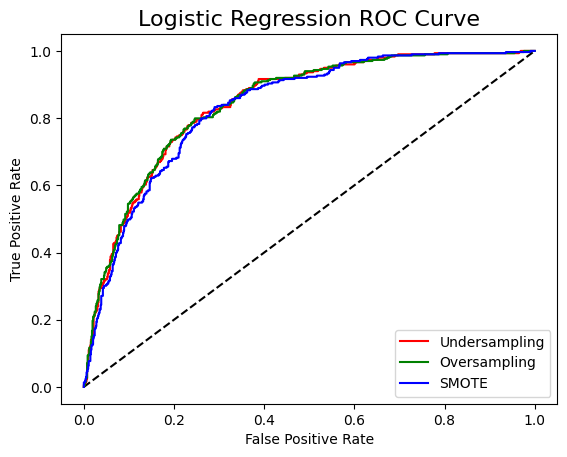

ROC_AUC Score - Undersampling :  84.36%
ROC_AUC Score - Oversampling :  84.45%
ROC_AUC Score - Smote :  83.38%


In [17]:
y_pred_prob = lr1.predict_proba(x_cv)[:,1]
y_pred_prob2 = lr2.predict_proba(x_cv)[:,1]
y_pred_prob3 = lr3.predict_proba(x_cv)[:,1]
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_prob)
fpr2, tpr2, thresholds = roc_curve(y_cv, y_pred_prob2)
fpr3, tpr3, thresholds = roc_curve(y_cv, y_pred_prob3)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Undersampling',color = "r")
plt.plot(fpr2, tpr2, label='Oversampling',color = "g")
plt.plot(fpr3, tpr3, label='SMOTE',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.legend()
plt.show();
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob)))
print("ROC_AUC Score - Oversampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob2)))
print("ROC_AUC Score - Smote : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob3)))

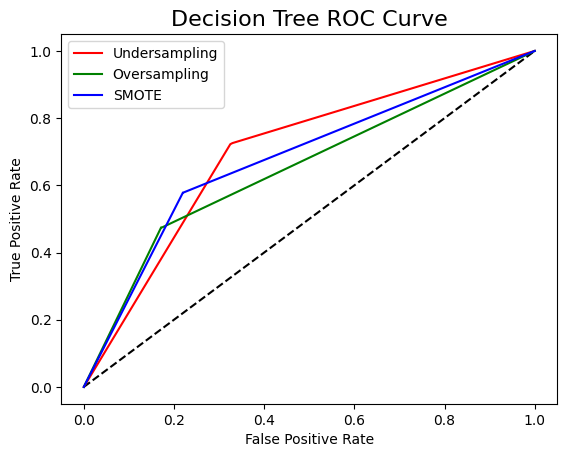

ROC_AUC Score - Undersampling :  69.92%
ROC_AUC Score - Oversampling :  65.11%
ROC_AUC Score - Smote :  67.91%


In [29]:
y_pred_prob = dt1.predict_proba(x_cv)[:,1]
y_pred_prob2 = dt2.predict_proba(x_cv)[:,1]
y_pred_prob3 = dt3.predict_proba(x_cv)[:,1]
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_prob)
fpr2, tpr2, thresholds = roc_curve(y_cv, y_pred_prob2)
fpr3, tpr3, thresholds = roc_curve(y_cv, y_pred_prob3)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Undersampling',color = "r")
plt.plot(fpr2, tpr2, label='Oversampling',color = "g")
plt.plot(fpr3, tpr3, label='SMOTE',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve',fontsize=16)
plt.legend()
plt.show();
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob)))
print("ROC_AUC Score - Oversampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob2)))
print("ROC_AUC Score - Smote : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob3)))

In [28]:
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob )))
print("ROC_AUC Score - Oversampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob2)))
print("ROC_AUC Score - Smote : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob3)))

ROC_AUC Score - Undersampling :  69.92%
ROC_AUC Score - Oversampling :  65.11%
ROC_AUC Score - Smote :  67.91%


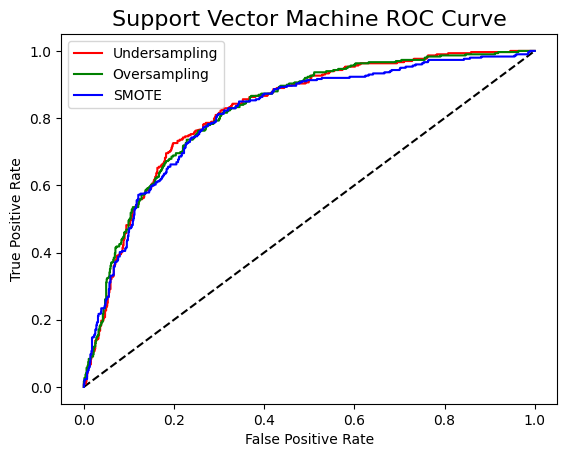

ROC_AUC Score - Undersampling :  82.32%
ROC_AUC Score - Oversampling :  82.26%
ROC_AUC Score - Smote :  81.03%


In [35]:
y_pred_prob = svc1.predict_proba(x_cv)[:,1]
y_pred_prob2 = svc2.predict_proba(x_cv)[:,1]
y_pred_prob3 = svc3.predict_proba(x_cv)[:,1]
fpr, tpr, thresholds = roc_curve(y_cv, y_pred_prob)
fpr2, tpr2, thresholds = roc_curve(y_cv, y_pred_prob2)
fpr3, tpr3, thresholds = roc_curve(y_cv, y_pred_prob3)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Undersampling',color = "r")
plt.plot(fpr2, tpr2, label='Oversampling',color = "g")
plt.plot(fpr3, tpr3, label='SMOTE',color = "b")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Machine ROC Curve',fontsize=16)
plt.legend()
plt.show();
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob)))
print("ROC_AUC Score - Oversampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob2)))
print("ROC_AUC Score - Smote : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob3)))

In [36]:
print("ROC_AUC Score - Undersampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob  )))
print("ROC_AUC Score - Oversampling : ",'{0:.2%}'.format(roc_auc_score(y_cv,y_pred_prob2)))
print("ROC_AUC Score - Smote : ",'{0:.2%}'.format(roc_auc_score(y_cv, y_pred_prob3)))

ROC_AUC Score - Undersampling :  82.32%
ROC_AUC Score - Oversampling :  82.26%
ROC_AUC Score - Smote :  81.03%


In [35]:
majority_class = y_train.value_counts().idxmax()
x_cv['target'] = majority_class

y_true = y_cv
y_pred = x_cv['target']

In [37]:
print(f"Classification Report : \n\n{classification_report(y_cv, y_pred)}")

Classification Report : 

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       828
           1       0.00      0.00      0.00       299

    accuracy                           0.73      1127
   macro avg       0.37      0.50      0.42      1127
weighted avg       0.54      0.73      0.62      1127



In [38]:
# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

fig = px.imshow(cm_df, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Negative', 'Predicted Positive'],
                y=['Actual Negative', 'Actual Positive'],
                color_continuous_scale=px.colors.sequential.Blues,text_auto=True)

fig.update_traces(showscale=True) 
fig.update_layout(title='Confusion Matrix - Baseline')
fig.show()

In [39]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print('Sensitivity: ' + str(sensitivity) + "\n"+'Specificity: '+ str(specificity))

Sensitivity: 0.0
Specificity: 1.0


In [40]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print('AUC score:', roc_auc)

AUC score: 0.5


In [37]:
# Create a DataFrame with the ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

fig = px.line(roc_df, x='fpr', y='tpr', title='ROC Curve (AUC=' + str(roc_auc) +')' + ' - Baseline',
              labels=dict(fpr='False Positive Rate', tpr='True Positive Rate'),width=500, height=450)
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, y0=0, x1=1, y1=1)
fig.show()